#Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import drive
drive.mount('/content/drive')
import h5py
import requests
from google.colab import userdata

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
tng_api_key = userdata.get('TNG_API_KEY')
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":tng_api_key}

In [5]:
def get(path, params=None):
    headers = {"api-key":tng_api_key}
    r = requests.get(path, params=params, headers=headers)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

#**Task 1**

For Illustris-1 at 𝑧=0
, get all the fields available for the subhalo with id=0 and print its total mass and stellar half mass radius.



In [ ]:
url = "http://www.tng-project.org/api/Illustris-1/snapshots/135/subhalos/0/"
#url: tng/api/Illustris-X/snapshots/X/z (redshift value)
r = get(url)

In [ ]:
r['mass'] #print total mass

22174.8

In [ ]:
r['halfmassrad_stars'] #print stellar half mass radius

72.0388

#**Task 2**

For Illustris-1 at 𝑧=2
, search for all subhalos with total mass 1011.9𝑀⊙<𝑀<1012.1𝑀⊙
, print the number returned, and the Subfind IDs of the first five results (arbitrarily ordered, you may get different ids).

In [ ]:
#convert the min and max masses into group catalog units
mass_min = 10**11.9 / 1e10 * 0.704
mass_max = 10**12.1 / 1e10 * 0.704

In [ ]:
#manually form the search_query string
search_query = "?mass__gt=" + str(mass_min) + "&mass__lt=" + str(mass_max)
search_query

'?mass__gt=55.920707724589455&mass__lt=88.6283489903093'

In [ ]:
url = "http://www.tng-project.org/api/Illustris-1/snapshots/z=2/subhalos/" + search_query
subhalos = get(url)
subhalos['count']
#getting the number of subhalos within that mass range

550

In [ ]:
ids = [ subhalos['results'][i]['id'] for i in range(5) ]
ids

[1, 1352, 5525, 6574, 12718]

#**Task 3**

For Illustris-1 at 𝑧=2
, retrieve all fields for five specific Subfind IDs (from above: 109974, 110822, 123175, 107743, 95711), print the stellar mass and number of star particles in each.

In [ ]:
ids = [109974, 110822, 123175, 107743, 95711] #separating selected ids
for id in ids:
    url = "http://www.tng-project.org/api/Illustris-1/snapshots/z=2/subhalos/" + str(id)
    subhalo = get(url)
    print (id, subhalo['mass_stars'], subhalo['len_stars'])
    # id, respective stellar mass, and number of star particles

109974 0.283605 7270
110822 0.41813 5820
123175 0.529888 11362
107743 0.648827 10038
95711 0.623781 12722


#**Task 4**

For Illustris-1 at 𝑧=2
, for five specific Subfind IDs (from above: 109974, 110822, 123175, 107743, 95711), extract and save full cutouts from the snapshot (HDF5 format).

In [ ]:
ids = [109974, 110822, 123175, 107743, 95711] #same ids from the task before
for id in ids:
    url = "http://www.tng-project.org/api/Illustris-1/snapshots/z=2/subhalos/" + str(id) + "/cutout.hdf5"
    saved_filename = get(url)
    print (id, saved_filename)

109974 cutout_109974.hdf5
110822 cutout_110822.hdf5
123175 cutout_123175.hdf5
107743 cutout_107743.hdf5
95711 cutout_95711.hdf5


#**Task 5**

For Illustris-1 at 𝑧=2
, for five specific Subfind IDs (from above: 109974, 110822, 123175, 107743, 95711), extract and save only star particles from the parent FoF halo of each subhalo.

In [ ]:
ids = [109974, 110822, 123175, 107743, 95711]
params = {'stars':'all'}
for id in ids:
    url = "http://www.tng-project.org/api/Illustris-1/snapshots/z=2/subhalos/" + str(id)
    sub = get(url)
    saved_filename = get(sub['cutouts']['parent_halo'],params)
    print (sub['id'], sub['grnr'], saved_filename)


109974 745 cutout_745.hdf5
110822 758 cutout_758.hdf5
123175 971 cutout_971.hdf5
107743 711 cutout_711.hdf5
95711 548 cutout_548.hdf5


#**Task 6**

For Illustris-1 at 𝑧=2
 for Subfind ID 109974, get a cutout including only the positions and metallicities of stars, and calculate the mean stellar metallicity in solar units within the annuli 3kpc<r<5kpc
 (proper) centered on the fiducial subhalo position.

In [ ]:
id = 109974
redshift = 2.0
params = {'stars':'Coordinates,GFM_Metallicity'}
scale_factor = 1.0 / (1+redshift)
little_h = 0.704
solar_Z = 0.0127
#not sure I understand the use of the last 3 in this list

In [ ]:
url = "http://www.tng-project.org/api/Illustris-1/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
sub = get(url) # get json response of subhalo properties
saved_filename = get(url + "/cutout.hdf5",params) # get and save HDF5 cutout file

In [ ]:
with h5py.File(saved_filename) as f:
    dx = f['PartType4']['Coordinates'][:,0] - sub['pos_x']
    dy = f['PartType4']['Coordinates'][:,1] - sub['pos_y']
    dz = f['PartType4']['Coordinates'][:,2] - sub['pos_z']
    metals = f['PartType4']['GFM_Metallicity'][:]
    rr = np.sqrt(dx**2 + dy**2 + dz**2)
    rr *= scale_factor/little_h # ckpc/h -> physical kpc
    w = np.where( (rr >= 3.0) & (rr < 5.0) )
    print (np.mean( metals[w] ) / solar_Z)

#"If the subhalo is near the edge of the box, you must take the periodic boundary into account! (we ignore it here)"

0.24839261


#**Task 7**

For Illustris-1 at 𝑧=2
, for five specific Subfind IDs (from above: 109974, 110822, 123175, 107743, 95711), locate the 𝑧=0
 descendant of each by using the API to walk down the SubLink descendant links.

In [ ]:
ids = [109974, 110822, 123175, 107743, 95711]
z0_descendant_ids = [-1]*len(ids)

In [ ]:
for i,id in enumerate(ids):
    start_url = "http://www.tng-project.org/api/Illustris-1/snapshots/68/subhalos/" + str(id)
    sub = get(start_url)
    while sub['desc_sfid'] != -1:
        sub = get(sub['related']['sublink_descendant'])
    if sub['snap'] == 135:
        z0_descendant_ids[i] = sub['id']
    if z0_descendant_ids[i] >= 0:
        print ('Descendant of ' + str(id) + ' at z=0 is ' + str(z0_descendant_ids[i]))
    else:
        print ('Descendant of ' + str(id) + ' not followed to z=0!')
# request the full subhalo details of the descendant by following the sublink URL

Descendant of 109974 at z=0 is 41092
Descendant of 110822 at z=0 is 338375
Descendant of 123175 at z=0 is 257378
Descendant of 107743 at z=0 is 110568
Descendant of 95711 at z=0 is 260067


#**Task 8**

For Illustris-1 at 𝑧=2
 track Subfind ID 109974 to 𝑧=0
, using the API to walk down the SubLink descendant links, and plot the mass evolution of each component (gas, dark matter, stars, and black holes)

In [ ]:
id = 109974
url = "http://www.tng-project.org/api/Illustris-1/snapshots/68/subhalos/" + str(id)
sub = get(url)

In [ ]:
fields = ['snap','id','mass_gas','mass_stars','mass_dm','mass_bhs']
r = {}
for field in fields:
    r[field]= []

In [ ]:
while sub['desc_sfid'] != -1:
    for field in fields:
        r[field].append(sub[field])
    sub = get(sub['related']['sublink_descendant'])
# request the full subhalo details of the descendant by following the sublink URL

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-316786850.py:7: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('Mass [log $M_\odot$]')
/tmp/ipython-input-316786850.py:3: RuntimeWarning: divide by zero encountered in log10
  mass_logmsun = np.log10( np.array(r['mass_'+partType])*1e10/0.704)


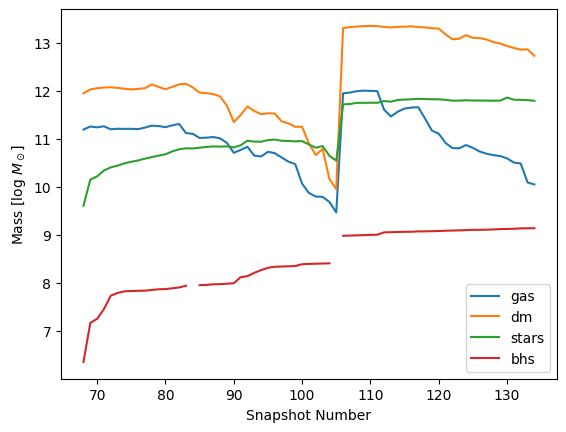

In [ ]:
# make a plot (notice our subhalo falls into a much more massive halo around snapshot 105)
for partType in ['gas','dm','stars','bhs']:
    mass_logmsun = np.log10( np.array(r['mass_'+partType])*1e10/0.704)
    plt.plot(r['snap'],mass_logmsun,label=partType)

plt.xlabel('Snapshot Number')
plt.ylabel('Mass [log $M_\odot$]')
plt.legend(loc='lower right');

#**Task 9**

For Illustris-1 at 𝑧=0
, check if pre-rendered mock stellar images exist for five specific Subfind IDs (the descendants from above: 41092, 338375, 257378, 110568, 260067). If so, download and display the PNGs.

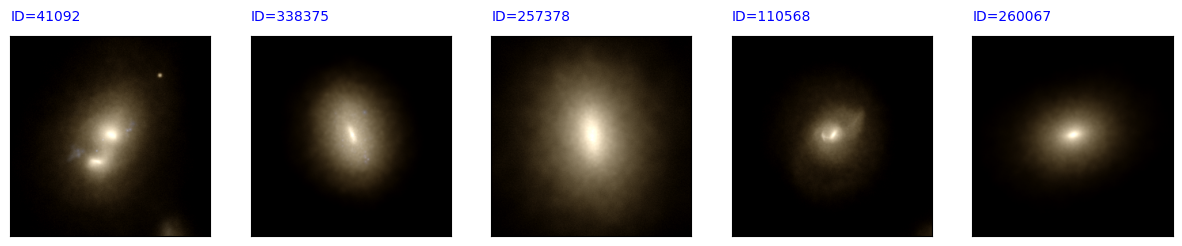

In [ ]:
from io import BytesIO

ids = [41092,338375,257378,110568,260067]

sub_count = 1
plt.figure(figsize=[15,3])

for id in ids:
    url = "http://www.tng-project.org/api/Illustris-1/snapshots/135/subhalos/" + str(id)
    sub = get(url)
    # it is of course possible this data product does not exist for all requested subhalos
    if 'stellar_mocks' in sub['supplementary_data']:
        png_url = sub['supplementary_data']['stellar_mocks']['image_fof']
        response = get(png_url) # download PNG image, the version which includes all stars in the FoF halo (try replacing 'fof' with 'gz')

        plt.subplot(1,len(ids),sub_count)
        plt.text(0,-20,"ID="+str(id),color='blue')
        plt.gca().axes.get_xaxis().set_ticks([])
        plt.gca().axes.get_yaxis().set_ticks([])
        sub_count += 1

        file_object = BytesIO(response.content) # plot the PNG binary data directly, without actually saving a .png file
        plt.imshow(mpimg.imread(file_object))
